In [1]:
import cooler
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, zscore, norm
from multiprocessing import Pool
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm as cm
import seaborn as sns

mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
# mpl.rcParams['font.family'] = 'sans-serif'
# mpl.rcParams['font.sans-serif'] = 'Helvetica'

In [2]:
ct = 'Oligo_NN'
ages = ['8wk','9mo','18mo']
leg = [f"{ct}.{age}" for age in ages]
leg

['Oligo_NN.8wk', 'Oligo_NN.9mo', 'Oligo_NN.18mo']

In [3]:
ctgroup = [[_leg] for _leg in leg]
ctgroup

[['Oligo_NN.8wk'], ['Oligo_NN.9mo'], ['Oligo_NN.18mo']]

In [4]:
leg = pd.Index(np.concatenate(ctgroup))
res = 10000

In [5]:
indir = '/data/female-amb/loop/'
outdir = f'loop_ct_age/diff/'

In [6]:
chrom_size_path = f'/ref/m3C/mm10.main.nochrM.nochrY.chrom.sizes'
chrom_sizes = cooler.read_chromsizes(chrom_size_path, all_names=True)

In [7]:
loopq = pd.read_hdf(f'{outdir}/{ct}/loop_Q.hdf', key='data')
loopt = pd.read_hdf(f'{outdir}/{ct}/loop_T.hdf', key='data')
loopall = pd.read_hdf(f'{outdir}/{ct}/merged_loop.hdf', key='data')

In [8]:
thres1 = norm.isf(0.025)
thres2 = norm.isf(0.15)
print(thres1, thres2)

1.9599639845400545 1.0364333894937898


In [9]:
selb = ((zscore(loopall['Qanova'])>thres2) & (zscore(loopall['Tanova'])>thres2))
distfilter = ((loopall[4]-loopall[1])>100000) & ((loopall[4]-loopall[1])<4950000) &  (loopall[1] >= (10*res)) & (loopall[4] < (loopall[0].map(chrom_sizes) - 10*res))
loopfilter = distfilter & selb
print(selb.sum(), loopfilter.sum())

13707 8836


In [10]:
loopall = loopall.loc[loopfilter]
loopq = loopq.loc[loopfilter]
loopt = loopt.loc[loopfilter]

In [11]:
loop_list = []
for ctlist in ctgroup:
    fc1 = loopq[ctlist].mean(axis=1) / loopq.loc[:, ~loopq.columns.isin(ctlist)].mean(axis=1)
    fc2 = loopt[ctlist].mean(axis=1) / loopt.loc[:, ~loopt.columns.isin(ctlist)].mean(axis=1)
    loop_list.append(loopall.loc[(fc1>1.2) & (fc2>1.5)])

In [12]:
[xx.shape[0] for xx in loop_list]

[2049, 102, 1173]

In [13]:
def apa(ct):
    result = np.zeros((len(loop_list), 21, 21))
    cool = cooler.Cooler(f'{indir}/{ct}/{ct}/{ct}.Q.cool')
    for c in np.random.permutation(chrom_sizes.index[:-1]):
        Q = cool.matrix(balance=False, sparse=True).fetch(c).toarray()
        decay = np.array([np.mean(np.diag(Q, k)) for k in range(dist)])
        E = np.zeros(Q.shape)
        row, col = np.diag_indices(E.shape[0])
        E[row, col] = 1
        for k in range(1, 505):
            E[row[:-k], col[k:]] = (Q[row[:-k], col[k:]]) / decay[k]
        for j,loop in enumerate(loop_list):
            looptmp = loop.loc[(loop[0]==c), [1,4]].values // res
            for xx,yy in looptmp:
                tmp = E[(xx-10):(xx+11), (yy-10):(yy+11)]
                tmp = (tmp - tmp.min()) / (tmp.max() - tmp.min())
                result[j] += tmp
                
    for j,loop in enumerate(loop_list):
        result[j] /= loop.shape[0]
        
    return result

In [14]:
cpu = 5
dist = 505
result = np.zeros((len(leg), len(loop_list), 21, 21))
with ProcessPoolExecutor(cpu) as executor:
    futures = {}
    for i,ct in enumerate(leg):
        future = executor.submit(
            apa,
            ct=ct,
        )
        futures[future] = i

    for future in as_completed(futures):
        idx = futures[future]
        result[idx] = future.result()
        print(f'{leg[idx]} finished')
        

Oligo_NN.18mo finished
Oligo_NN.8wk finished
Oligo_NN.9mo finished


[]

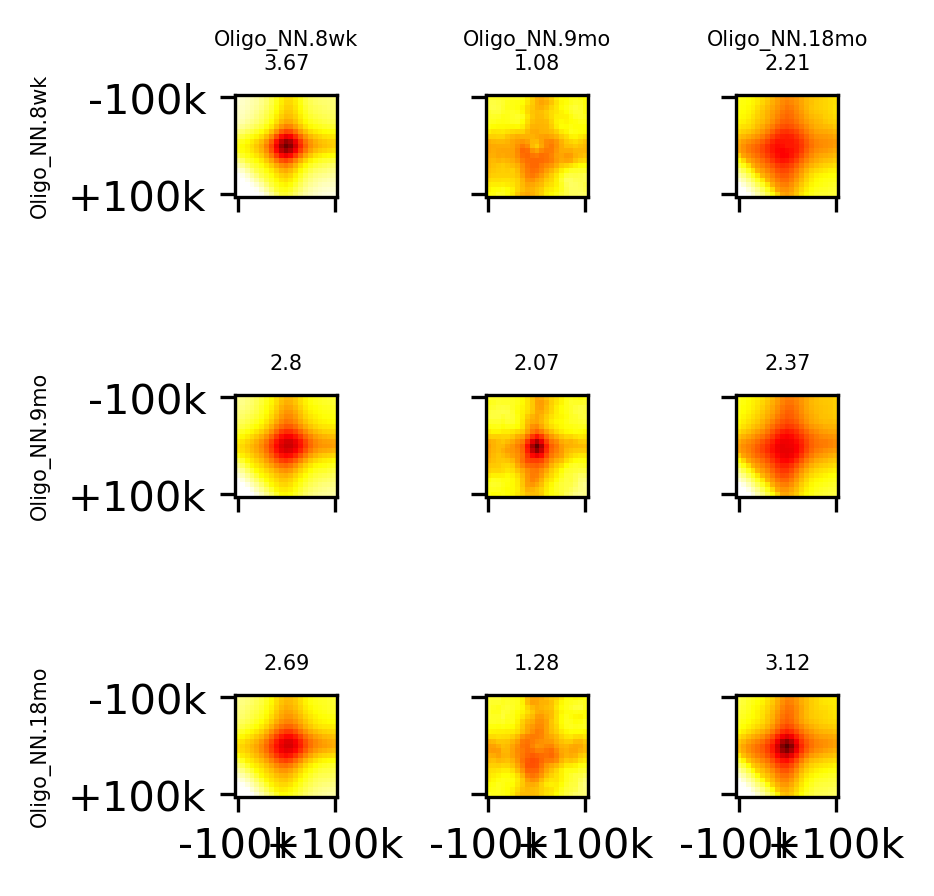

In [15]:
fig, axes = plt.subplots(len(leg), len(loop_list), figsize=(len(loop_list),len(leg)), 
                         sharex='all', sharey='all', dpi=300, constrained_layout = True)
fig.subplots_adjust(wspace=0.2, hspace=0.6)
for i,ct in enumerate(leg):
    for j,loop in enumerate(loop_list):
        ax = axes[i, j]
        tmp = result[i, j]
        apa = np.around(tmp[10,10]/tmp[-5:, :5].mean(), decimals=2)
        ax.imshow(tmp, cmap='hot_r', vmax=0.8, vmin=0.2)
        if i==0:
            ax.set_title(f'{leg[j]}\n{apa}', fontsize=5)
        else:
            ax.set_title(apa, fontsize=5)
            
for i,ct_age in enumerate(leg):
    axes[i,0].set_ylabel(ct_age, fontsize=5)
        
ax.set_xticks([0, 20])
ax.set_xticklabels(['-100k', '+100k'])
ax.set_yticks([0, 20])
ax.set_yticklabels(['-100k', '+100k'])

# plt.tight_layout()
# plt.savefig(f'{indir}diff/plot/{group_name}_diffloop_apa.pdf', transparent=True)